In [568]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import torch
from torch import nn

In [569]:
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

In [570]:
train = pd.read_csv("data/bicikelj_train.csv")
train["timestamp"] = pd.to_datetime(train["timestamp"])

test = pd.read_csv("data/bicikelj_test.csv")
test["timestamp"] = pd.to_datetime(test["timestamp"])

In [571]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [572]:
# Build a linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, device="cuda")
    
    def forward(self, x):
        return self.linear(x)

In [573]:
def datetime64_to_unix(timestamp):
    """
    Convert a pandas DataFrame column of numpy.datetime64 objects to Unix timestamps in float format.
    
    Parameters:
        timestamp (pandas.Series): The column of timestamps to convert.
    
    Returns:
        pandas.Series: A new column of Unix timestamps.
    """
    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the difference in seconds between the timestamp and Unix epoch
    seconds = (timestamp - unix_epoch) / np.timedelta64(1, 's')
    
    return pd.Series(seconds)


def unix_to_datetime64(unix_timestamp):
    """
    Convert a pandas DataFrame column of Unix timestamps in float format to numpy.datetime64 objects.
    
    Parameters:
        unix_timestamp (pandas.Series): The column of Unix timestamps to convert.
    
    Returns:
        pandas.Series: A new column of numpy.datetime64 objects.
    """
    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the timedelta from the Unix timestamp in seconds
    timedelta = pd.to_timedelta(unix_timestamp, unit='s')
    
    # Add the timedelta to the Unix epoch to get the resulting datetime64 objects
    timestamp = unix_epoch + timedelta
    
    return pd.Series(timestamp)


In [721]:
def plot_loss(epochs, train_losses, test_losses=None):
    plt.plot(epochs, train_losses, label="Train loss")
    if test_losses is not None:
        plt.plot(epochs, test_losses, label="Test loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [576]:
def plot_bikes(train_df: pd.DataFrame, n_stations = 5, stations: list = None, random_state=42, howmany=100):
    times = train_df["timestamp"]
    stations_to_plot = None
        
    if stations is not None:
        stations_to_plot = train_df.loc(stations)
    elif n_stations is not None:
        stations_to_plot = train_df.drop("timestamp", axis=1).sample(n_stations, random_state=random_state, axis=1)
        
    fig, ax = plt.subplots(figsize=(20, 10))    
    
    print(stations_to_plot.shape)
    for station in stations_to_plot:
        ax.plot(times[:howmany], stations_to_plot[station].values[:howmany], label=station)
        
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of bikes')
    ax.set_title('Time Series Data')
    ax.legend()
    


(7739, 5)


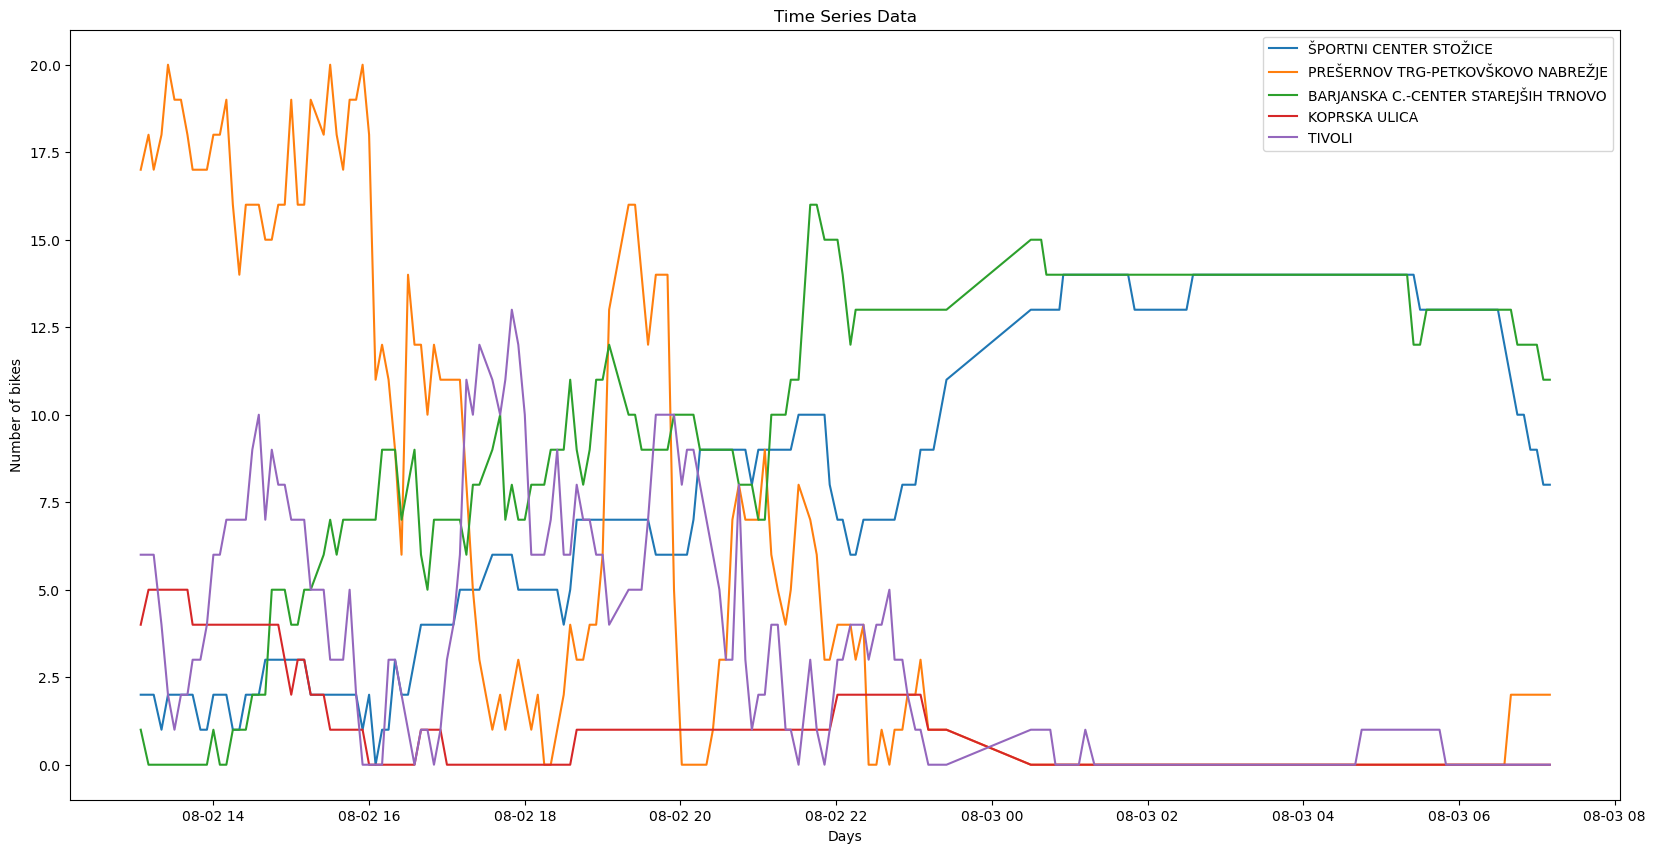

In [577]:
plot_bikes(train, n_stations=5, howmany=200)

In [579]:
# Extract new features
def get_time_based_features(timestamp):
    # From datetime64 get month, day, hour, dayOfWeek and isHoliday
    timestamp = np.datetime64(timestamp)
    dt_python = timestamp.astype(datetime.datetime)

    # Extract month, day, hour, and day_of_week
    month = dt_python.month
    day = dt_python.day
    hour = dt_python.hour
    minute = dt_python.minute
    day_of_week = dt_python.weekday()

    # Check for holidays
    is_holiday = 0
    if dt_python.month == 8 and dt_python.day in [15, 17]:
        is_holiday = 1
    elif dt_python.month == 9 and dt_python.day in [15, 23]:
        is_holiday = 1
   
    return month, day, hour, minute, day_of_week, is_holiday

In [580]:
# Get list of stations
stations = []
for i in range(1, 84):
    stations.append(train.columns[i])

In [581]:
# def get_shifted_rows(df, timestamp, timediff, station):
#     shifted_timestamp = timestamp - pd.DateOffset(hours=timediff)
#     shifted_row = df.loc[df['timestamp'] == shifted_timestamp, station]
#     return shifted_row.values[0] if not shifted_row.empty else 0

# for station in stations:
#     train[f"{station}_1hr"] = train.apply(lambda row: get_shifted_rows(train, row['timestamp'], 1, station), axis=1)
#     train[f"{station}_2hr"] = train.apply(lambda row: get_shifted_rows(train, row['timestamp'], 2, station), axis=1)


In [602]:
# Add new features to train
# train['month'], train['day'], train['hour'], train['minute'], train['day_of_week'], train['is_holiday'] = zip(*train['timestamp'].map(get_time_based_features))

In [604]:
# train.to_csv("data/processed_data.csv", index=False)

In [605]:
d = pd.read_csv("data/processed_data.csv")
ix = 1
for station in stations:
    if d.iloc[ix][station] - d.iloc[ix + 12][f'{station}_1hr'] != 0:
        print(f"{station} time: {d.iloc[ix]['timestamp']} - {d.iloc[ix + 12]['timestamp']}: n-bikes vs n_bikes_1hr {d.iloc[ix][station]} {d.iloc[ix + 12][f'{station}_1hr']}")

In [606]:
train = pd.read_csv("data/processed_data.csv")
train.columns

Index(['timestamp', 'PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE',
       'POGAČARJEV TRG-TRŽNICA', 'KONGRESNI TRG-ŠUBIČEVA ULICA',
       'CANKARJEVA UL.-NAMA', 'BREG', 'GRUDNOVO NABREŽJE-KARLOVŠKA C.',
       'MIKLOŠIČEV PARK', 'BAVARSKI DVOR', 'TRG OF-KOLODVORSKA UL.',
       ...
       'VOKA - SLOVENČEVA_1hr', 'VOKA - SLOVENČEVA_2hr',
       'SUPERNOVA LJUBLJANA - RUDNIK_1hr', 'SUPERNOVA LJUBLJANA - RUDNIK_2hr',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'is_holiday'],
      dtype='object', length=256)

### Models and data
For each station, get the following columns:
- timestamp
- month
- day
- hour
- minute
- n_bikes_1h
- n_bikes_2h
- is_holiday
- day_of_week


In [608]:
station_dataframes = {}

for station in stations:
    station_df = pd.DataFrame({
        "timestamp": train["timestamp"].values,
        "n_bikes": train[station].values,
        "month": train["month"].values,
        "day": train["day"].values,
        "hour": train["hour"].values,
        "minute": train["minute"].values,
        "day_of_week": train["day_of_week"].values,
        "is_holiday": train["is_holiday"].values,
        "n_bikes_1hr": train[f"{station}_1hr"].values,
        "n_bikes_2hr": train[f"{station}_2hr"].values
    })
    
    station_dataframes[station] = station_df
    
    station = station.replace("/", "_")
    station_df.to_csv(f"data/stations/{'_'.join(station.split(' '))}.csv", index=False)
    
    

In [695]:
def model_test(X_test, y_test, model, loss_fn, epoch, test_losses: list = None):
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test.to(device))
        test_loss = loss_fn(test_pred, y_test.to(device))
        
        if epoch % 100 == 0:
            if test_losses is not None:
                test_losses.append(test_loss.cpu().numpy())
   
            print(f"Test loss: {test_loss.cpu().detach().numpy()}")
            
    return test_losses

# Training loop
def model_train(X_train, X_test, y_train, y_test, model, loss_fn, optimizer, epochs=10, epochs_list: list = None, train_losses: list = None, test_losses: list = None, scheduler=None):
    for epoch in range(epochs):
        model.train()   # Set mode
        
        # Forward pass and loss
        y_pred = model(X_train.to(device))
        train_loss = loss_fn(y_pred, y_train.to(device))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # test_losses = model_test(X_test, y_test, model, loss_fn, epoch, test_losses)
        
        if epoch % 100 == 0:
            train_losses.append(train_loss.cpu().detach().numpy())
            epochs_list.append(epoch)

            print(f"Epoch: {epoch}, Train loss: {train_loss.cpu().detach().numpy()}")
        if scheduler is not None:
            scheduler.step()
    return epochs_list, train_losses, test_losses
        

In [706]:
presernov_df = station_dataframes[stations[0]]

X = presernov_df.drop(["timestamp", "n_bikes"], axis=1)
y = np.array(presernov_df["n_bikes"]).reshape((-1, 1))

In [716]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

n_epochs = 10000

X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

# y_train = y_train.unsqueeze(1)
# y_test = y_test.unsqueeze(1)

# Element-wise multiplication
y_train = torch.mul(X_train, y_train)
y_test = torch.mul(X_test, y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([6191, 8]),
 torch.Size([6191, 8]),
 torch.Size([1548, 8]),
 torch.Size([1548, 8]))

In [736]:
from sklearn.metrics import r2_score
from sklearn import linear_model

def linear_regression(X_train, X_test, y_train, y_test):
        # Fit model
    lr = linear_model.Lasso()
    # lr = Lasso(alpha=1)
    lr.fit(X_train, y_train)

    coefs = lr.coef_
    print(coefs.shape)

    for i in range(len(coefs)):
        if coefs[i].any() == 0:
            print(f"Removed {X.columns[i]}")
        else:
            print(f"{unix_to_datetime64(X[i])}: {lr.coef_[i]}")
    
    # Predict and score
    y_pred = lr.predict(X_test)
    
    plt.scatter(y_test, y_pred)
    
    score = r2_score(y_test, y_pred)
    return lr, score

linear_regression(X_train, X_test, y_train, y_test)

(8, 8)


KeyError: 0

In [743]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(X_train, X_test, y_train, y_test):
        # Fit model
    rf = RandomForestRegressor()
    # lr = Lasso(alpha=1)
    rf.fit(X_train, y_train)

    # Predict and score
    y_pred = rf.predict(X_test)
    
    plt.scatter(y_test, y_pred)
    
    score = r2_score(y_test, y_pred)
    return rf, score

0.21970384898093936

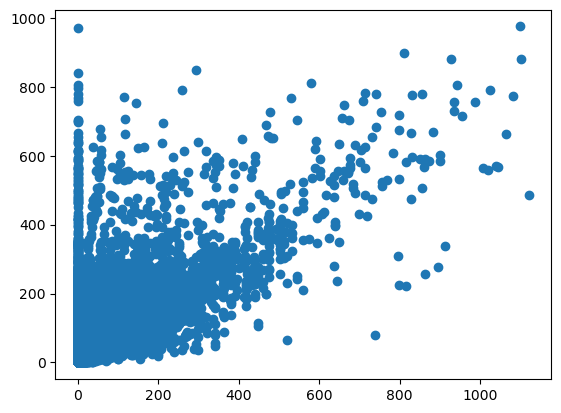

In [744]:
rf, score = random_forest(X_train, X_test, y_train, y_test)
# plt.bar(len(rf.feature_importances_), rf.feature_importances_)
score

In [717]:
X.shape, y.shape

((7739, 8), (7739, 1))

In [718]:
# Train model for a single station
presernov_model = LinearRegression(X.shape[1], y.shape[1])


In [719]:
lr = 0.1
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(single_station_model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.7)

In [720]:
train_losses, test_losses, epochs = [], [], []

epochs, train_losses, test_losses = model_train(X_train, X_test, y_train, y_test, presernov_model, loss_fn, optimizer, n_epochs, epochs, train_losses, test_losses)


Epoch: 0, Train loss: 68.68353271484375
Epoch: 100, Train loss: 68.68353271484375
Epoch: 200, Train loss: 68.68353271484375
Epoch: 300, Train loss: 68.68353271484375
Epoch: 400, Train loss: 68.68353271484375
Epoch: 500, Train loss: 68.68353271484375
Epoch: 600, Train loss: 68.68353271484375
Epoch: 700, Train loss: 68.68353271484375
Epoch: 800, Train loss: 68.68353271484375
Epoch: 900, Train loss: 68.68353271484375
Epoch: 1000, Train loss: 68.68353271484375
Epoch: 1100, Train loss: 68.68353271484375
Epoch: 1200, Train loss: 68.68353271484375
Epoch: 1300, Train loss: 68.68353271484375
Epoch: 1400, Train loss: 68.68353271484375
Epoch: 1500, Train loss: 68.68353271484375
Epoch: 1600, Train loss: 68.68353271484375
Epoch: 1700, Train loss: 68.68353271484375
Epoch: 1800, Train loss: 68.68353271484375
Epoch: 1900, Train loss: 68.68353271484375
Epoch: 2000, Train loss: 68.68353271484375
Epoch: 2100, Train loss: 68.68353271484375
Epoch: 2200, Train loss: 68.68353271484375
Epoch: 2300, Train loss

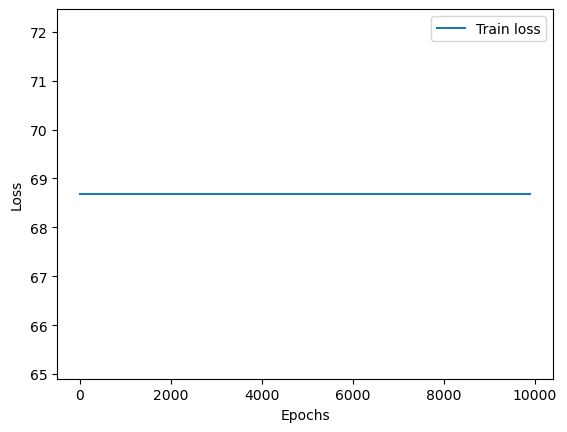

In [723]:
plot_loss(epochs, train_losses)

(1548, 1)


IndexError: too many indices for tensor of dimension 2

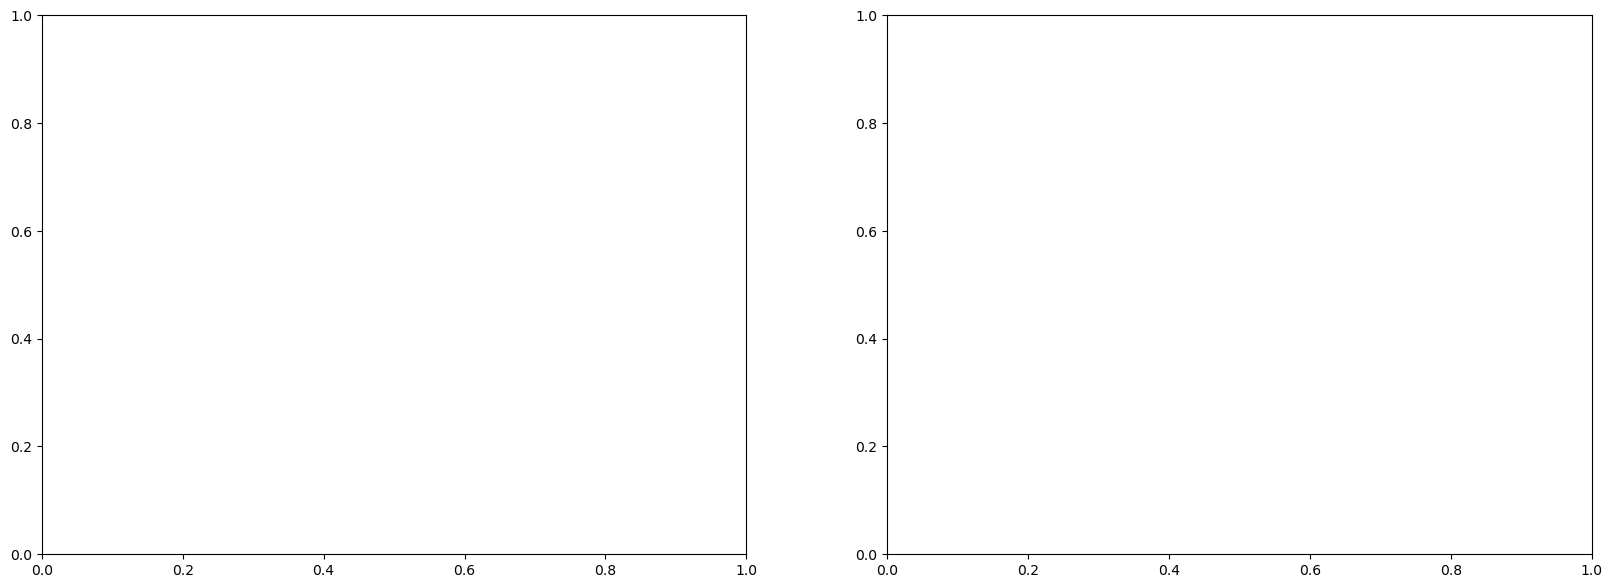

In [727]:
with torch.inference_mode():
    y_pred = presernov_model(X_test.to(device))
    # print(y_pred.cpu())
    print(y_pred.cpu().detach().numpy().shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
        
    ax[0].plot(X_test[], y_pred.cpu().detach().numpy(), label="Predicted")
    ax[1].plot(X_test["hour"], y_test.cpu().detach().numpy(), label="Real")
    ax[0].legend(), ax[1].legend()